# Introduction
This notebook isn't predictions of epidemic development but an attempt to answer if we have an uptrend, permanent or downtrend trend in different time horizons by using technical indicators.

## ETL

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Import data and add one more column 'day' as index.

In [2]:
df = pd.read_csv('poland_daily.csv', sep=';')
df['date'] = pd.to_datetime(df['date'])
df['day'] = range(1, len(df) + 1)
df.head()

,date,infected,day
0,2020-04-03,1,1
1,2020-05-03,0,2
2,2020-06-03,4,3
3,2020-07-03,1,4
4,2020-08-03,5,5


## GMAA
The Guppy Multiple Moving Average (GMMA) is a technical indicator that identifies changing trends, breakouts, and trading opportunities in the price of an asset by combining two groups of moving averages (MA) with different time periods. 

* In our case we can map it to:
When the short-term group of averages moves above the longer-term group, it indicates an epidemic uptrend could be emerging.

* When the short-term group falls below the longer-term group of MAs, an epidemic downtrend could be starting.

* When there is lots of separation between the MAs, this helps confirm the epidemic trend in the current direction.

### Prepare simple moving averages

In [3]:
sma = {}
sma['yellow'] = [2, 3, 4, 5, 6, 7]
sma['orange'] = [9, 10, 11, 12, 13]
sma['blue']   = [15, 17, 19, 21, 23]
sma['green']  = [25, 27, 29, 31, 33]
sma['red']    = [35, 37, 40, 43]

In [4]:
for (color) in sma:
    for window_size in sma[color]:
        sma_name = 'SMA_' + str(window_size)
        df[sma_name] = df.iloc[:,1].rolling(window=window_size).mean()

### Plot GMMA

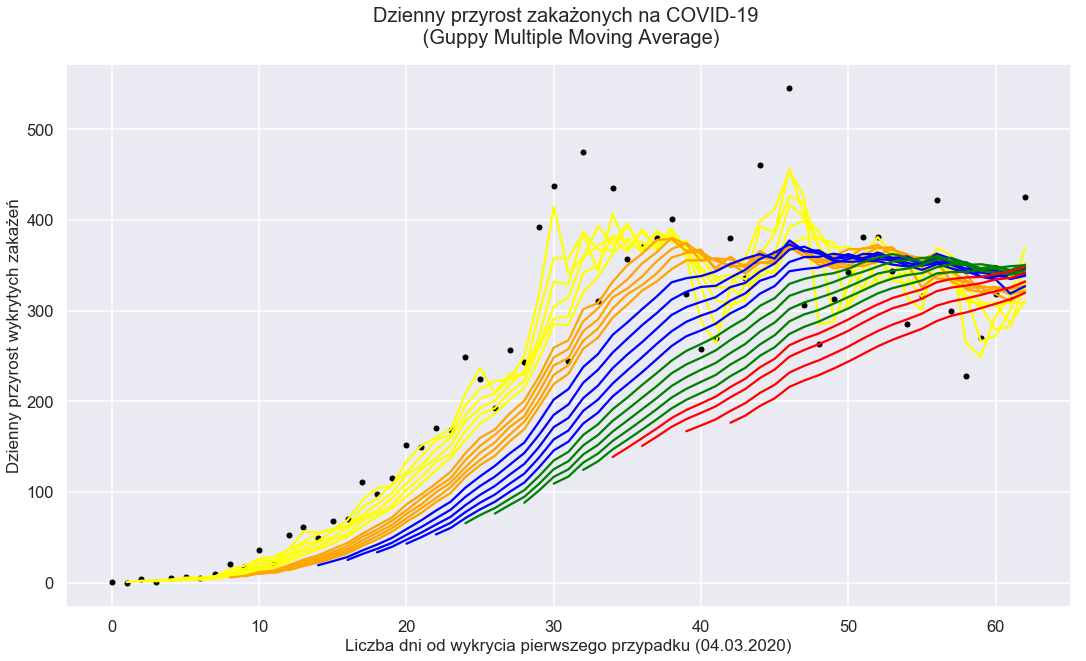

In [5]:
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

plt.figure(figsize=[18,10])
plt.grid(True)
plt.title('Dzienny przyrost zakażonych na COVID-19 \n (Guppy Multiple Moving Average)', fontsize=20, pad=20)
plt.xlabel('Liczba dni od wykrycia pierwszego przypadku (04.03.2020)', fontsize=17)
plt.ylabel('Dzienny przyrost wykrytych zakażeń', fontsize=17)

plt.plot(df['infected'], 'ko',label='Dzienny przyrost', markersize=5)

for (color) in sma:
    for window_size in sma[color]:
        sma_name = 'SMA_' + str(window_size)
        plt.plot(df[sma_name], color)